In [1]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "segmentation"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [2]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcfs_with_context.tsv", sep="\t")
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs[['orientation','context']], prefix="", prefix_sep="")), axis=1)
ctcfs = ctcfs.rename(columns={'>': 'forward', '<': 'reverse'})
ctcfs = ctcfs.merge(pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t"), on=src.coords + ['orientation'])
ctcfs.head()

,chr,start,end,orientation,context,reverse,forward,C,CD,D,S,T,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,T,0,1,0,0,0,0,1,0,9.790746,12.637052,1.392043e+09
1,chr1,521337,521697,>,S,0,1,0,0,0,1,0,1,10.259412,13.835230,1.563464e+09
2,chr1,714087,714447,>,S,0,1,0,0,0,1,0,2,9.893988,9.332479,1.241503e+09
3,chr1,805232,805362,>,S,0,1,0,0,0,1,0,3,14.365820,46.633221,3.272974e+09
4,chr1,839966,840326,>,S,0,1,0,0,0,1,0,4,16.393501,60.461779,3.574601e+09


In [52]:
path = src.external_data_path / "segmentation" / "hg19_M0_CB.bed"
segmentation = pd.read_csv(path, sep="\t", header=None, names = src.coords + ['state'])
states = segmentation.state.str.split('_', expand=True)
states.columns = ['code', 'name', 'n']
segmentation = pd.concat((segmentation, states), axis=1)
segmentation.head()

,chr,start,end,state,code,name,n
0,chr1,10400,13800,E11_weak_1,E11,weak,1
1,chr1,13800,14200,E12_gene_1,E12,gene,1
2,chr1,14200,19400,E13_gene_1,E13,gene,1
3,chr1,19400,21400,E12_gene_2,E12,gene,2
4,chr1,21400,22000,E23_proximal_1,E23,proximal,1


In [53]:
segs_with_ctcfs = BedTool.from_dataframe(segmentation.sort_values(src.coords))\
                            .intersect(BedTool.from_dataframe(ctcfs), wa=True, wb=True)\
                            .to_dataframe(names=segmentation.columns.tolist() + 
                                          ctcfs.columns.map(lambda x: "ctcf_" + x if x in segmentation.columns else x).tolist())
segs_with_ctcfs.head()

,chr,start,end,state,code,name,n,ctcf_chr,ctcf_start,ctcf_end,...,forward,C,CD,D,S,T,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,713380,715180,E8_proximal_4,E8,proximal,4,chr1,714087,714447,...,1,0,0,0,1,0,2,9.893988,9.332479,1.241503e+09
1,chr1,793180,812780,E18_dead_9,E18,dead,9,chr1,805232,805362,...,1,0,0,0,1,0,3,14.365820,46.633221,3.272974e+09
2,chr1,825180,844580,E20_dead_22,E20,dead,22,chr1,839966,840326,...,1,0,0,0,1,0,4,16.393501,60.461779,3.574601e+09
3,chr1,846180,855980,E20_dead_23,E20,dead,23,chr1,848092,848452,...,1,1,0,0,0,0,5,3.070639,3.042261,9.889943e+07
4,chr1,856380,856580,E22_poised_2,E22,poised,2,chr1,856454,856704,...,0,1,0,0,0,0,6,9.596212,5.703761,9.090222e+08


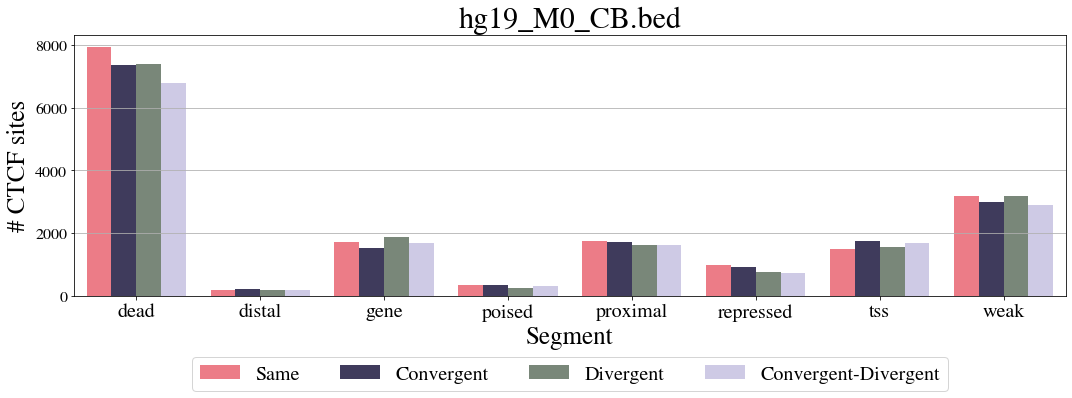

In [54]:
plt.figure(figsize=(15, 6))
sns.countplot(data=segs_with_ctcfs.assign(context=lambda x: x.context.map(src.ctcf_class_to_name)), x='name', hue='context',
              order=sorted(segmentation.name.unique()),
              hue_order=['Same', 'Convergent', 'Divergent', 'Convergent-Divergent'], 
              palette=src.ctcf_name_colormap)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("Segment", fontsize=25)
plt.ylabel("# CTCF sites", fontsize=25)
plt.grid(axis='y')
plt.title(str(path).split("/")[-1], fontsize=30)
plt.legend(fontsize=20, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.show()